# Project: Spam/Ham Classification

## Feature Engineering, Logistic Regression

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

## This Assignment
You will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and your written responses in this notebook.

You should feel comfortable with the following:

- Feature engineering with text data
- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
This is a **real world** dataset – the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the homework so that you are made aware.

In [2]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 1: Initial Analysis

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

### Background (given): 

 - In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

 - The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

 - Note: The dataset is from 2004, so the contents of emails might be very different from those in 2022.

 - In the following cells load the data into DataFrames.

 - The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

 - 1. `id`: An identifier for the training example
 - 2. `subject`: The subject of the email
 - 3. `email`: The text of the email
 - 4. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

 - The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [1]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [5]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Check if  data contains any missing values: In the cell below to print the number of NaN values in each column. If there are NaN values, we replace them with appropriate filler values. Here NaN values in the `subject` or `email` columns will be replaced with empty strings. Finally, we print the number of NaN values in each column after this modification to verify that there are no NaN values left.


In [6]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


<br/>

<hr style="border: 1px solid #fdb515;" />

## Initial Explorataion

In the cell below, I am looking at the text of the `email` field for the first ham and the first spam email in the original training set.

In [7]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



I can see that the body text is different between the two emails. The ham email has a many of links that are all 'www' and '.com'/'.net' links. Or links that seem to be legitimate. Whereas the spam email text has a link that seems to be illegitimate because it is not a 'www' link and is instead a hard link. In addition there appears to be a lot more formatting (head, body, br, etc) done to the text in the spam email than to the text in the ham email. It follows that one of the key features in my feature engineering pipeline might be the context of the emails (body/subject), especially considering we do not have metadata on the emails.

## Training-Validation Split
### Instructions:
- The training data we downloaded is all the data we have available for both training models and **validating** the models that we train. Split the training data into separate training and validation datsets.

In [8]:
# Creating a 90/10 train-validation split on our labeled data

from sklearn.model_selection import train_test_split

#Seed is set to 42 as required for the autograder to run

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 2: Basic Feature Engineering

### Instructions: 
- In your project, one of the features you may choose to use is whether or not a word appears in the email. Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

The goal of this project is to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so I can use logistic regression to train a classifier. Recall that to train a logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$. To address the fact that our data are text, not numbers, we can create numeric features derived from the email text and use those features for logistic regression.

To this end we can create the `words_in_texts` function as described above.

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import numpy as np
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array


<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Basic EDA
### Instructions:
- Conduct some basic EDA on the data, creating plots/visualizations and explaining your process

We need to identify some features that allow us to distinguish spam emails from ham emails. One way we can do this is by comparing the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this means comparing the proportion of spam emails with the word to the proportion of ham emails with the word.

Here I am creating a bar chart comparing the proportion of spam and ham emails containing certain words. Note that I am only considering the emails from the `train` ste


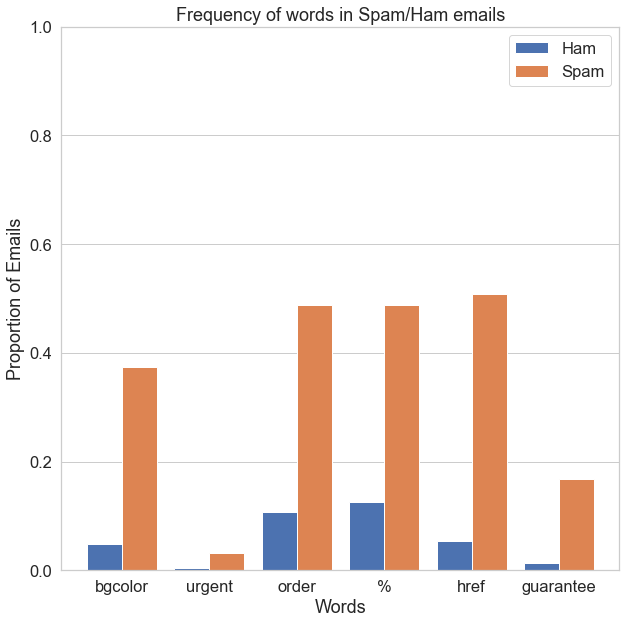

In [10]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
train['type'] = train['spam'].map({0:'ham', 1:'spam'})
train_spam = train[train['type'] == "spam"]
train_ham = train[train['type'] == "ham"]


spam_array = words_in_texts(['bgcolor', 'urgent', 'order', '%', 'href', 'guarantee'], train_spam['email'])
ham_array = words_in_texts(['bgcolor', 'urgent', 'order', '%', 'href', 'guarantee'], train_ham['email'])

spam_sums = [sum([array[i] for array in spam_array]) for i in range(6)]
ham_sums = [sum([item[j] for item in ham_array]) for j in range(6)]

spam_prop = np.array(spam_sums)/len(train_spam)
ham_prop = np.array(ham_sums)/len(train_ham)

words_lst = ['bgcolor', 'urgent', 'order', '%', 'href', 'guarantee']
plt.figure(figsize=(10,10))
plt.bar(np.arange(len(words_lst)) - 0.2, height = ham_prop, width= 0.4, label = 'Ham')
plt.bar(np.arange(len(words_lst))+ 0.2, height = spam_prop, width = 0.4, label = 'Spam')

plt.xticks(np.arange(len(words_lst)), words_lst)
plt.ylim(0.0, 1.0)
plt.xlabel("Words")
plt.ylabel("Proportion of Emails")
plt.title("Frequency of words in Spam/Ham emails")
plt.legend(loc = 'upper right')
plt.grid(False, axis = 'x')
plt.show()


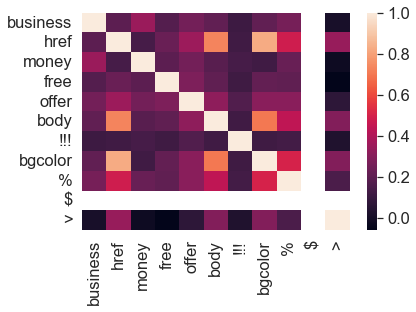

In [15]:
#heatmap of words correlation with each other maybe also do spam vs ham 
    #if two words have really high correlation, then maybe they are redundant 
    #(don't need both of them) and we would just choose one to avoid multi colinearity 
#heatmap 
#frequency of words that appear in spam emails compared to words that you put together 


corrs = X_train2[['business', 'href', 'money', 'free', 
              'offer', 'body', '!!!', 'bgcolor', '%', '$', '>']].corr()
sns.heatmap(corrs);

Above is a heatmap of certain words that I was using in my words_in_text function. I knew that if two words have really high correlation, then maybe they are redundant. Since they are highly correlated, this means that the appearance of one is highly associated with the appearance of the other. So there would not be a big need to use both of them, and I would be able to just choose one to avoid multi-colinearity. This worked pretty well, but there were a few exceptions, where actually including 2 highly correlated words improved my model performance -- for example '$' was highly correlated with everything but was also helpful in building my model.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 3 - Building Your Own Model

### Instructions: 
- In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Gradescope.

- **Gradescope limits you to four submissions per day**. You will be able to see your accuracy on the entire test set when submitting to Gradescope.

- You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc.

- We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering short questions 1, 2, and 3 should help guide you.

In [11]:
#feature engineering our training data

email_words = ['business', 'href', 'money', 'html', 
              'offer', 'body', '!!!', 'bgcolor',
              'rich', '%', '$', 'debt', 
              'payment', 'free','rate', 'spam',
              'helvetica', '<font', 'arial', 'guaranteed', 
               'please', 'people', 'make', 'send', 
               'reply', '</tr>', 'memo', 'removed', 
              'sex', 'dear', 'border', 'wish', 
              'million', 'shipping', '>', '2002']

def feature_eng(text, words_lst):     
    train_df = pd.DataFrame(words_in_texts(words_lst, text), index = text.index)
    train_df.columns = words_lst
    train_df['prop </'] = text.str.count('</')/text.astype('string').str.len()
    train_df['prop you'] = text.str.count('you')#/text.astype('string').str.len()
    train_df['prop your'] = text.str.count('your')/text.astype('string').str.len()
    train_df['prop !'] = text.str.count('!')/text.astype('string').str.len()
    train_df['prop reply'] = text.str.count('reply')/text.astype('string').str.len()
    train_df['prop $'] = text.str.count('$')/text.astype('string').str.len()
    train_df['len email'] = text.astype('string').str.len()
    return train_df
    
X_train2 = feature_eng(train['email'], email_words)
Y_train2 = np.array(train['spam'])

X_train2[:5], Y_train2[:5]

(   business  href  money  html  offer  body  !!!  bgcolor  rich  %  ...  \
 0         0     0      0     0      0     0    0        0     0  0  ...   
 1         0     0      0     1      0     1    0        0     0  1  ...   
 2         0     0      0     0      0     0    0        0     0  0  ...   
 3         0     0      0     1      0     0    0        0     0  0  ...   
 4         1     1      0     1      1     1    0        1     1  1  ...   
 
    shipping  >  2002   prop </  prop you  prop your    prop !  prop reply  \
 0         0  0     1       0.0         0        0.0  0.001219         0.0   
 1         0  0     1       0.0         1        0.0       0.0         0.0   
 2         0  1     1       0.0         1        0.0  0.002144         0.0   
 3         0  0     1       0.0         1        0.0  0.000451         0.0   
 4         0  1     1  0.010683        17   0.000183  0.001339         0.0   
 
      prop $  len email  
 0  0.001219       1641  
 1  0.000424       4

In [13]:
# fitting our model to the feature engineered training data

from sklearn.linear_model import LogisticRegression

#FINDING TRAINING ACCURACY 
model2 = LogisticRegression(max_iter = 1000)
model2.fit(X_train2, Y_train2)

training_accuracy2 = model2.score(X_train2, Y_train2)
print("Training Accuracy: ", training_accuracy2)

Training Accuracy:  0.926128044722481


In [14]:
#FINDING VALIDATION ACCURACY  
X_train3 = feature_eng(val['email'], email_words)
Y_train3 = np.array(val['spam'])

model3 = LogisticRegression(max_iter = 1000)
model3.fit(X_train3, Y_train3)

training_accuracy3 = model3.score(X_train3, Y_train3)
print("Validation Accuracy: ", training_accuracy3)

Validation Accuracy:  0.9233532934131736


### Short Questions: Feature/Model Selection Process

1. How did you find better features for your model?
 -  I used the training accuracy as a metric for finding features for my model. I aimed to get a training accuracy between 90% and 95% when adding in features, and I removed features that lowered the training accuracy below this. I wanted above 90% because I wanted the model to be able to accurately predict the spam/ham classification but I wanted the training accuracy to be less than 95% because I didn't want to be overfitting to the training data. I also used the gradescope submissions as a metric for how well my model was performing. For finding better words to filter for, I looked at the training data pretty carefully to try and see what words appeared more often in the spam vs ham emails. I ended up creating 2 dictionaries of all of the words in the spam and ham emails and their value counts.    In addition, I looked for differences in the number and type of punctuation used and the structure of the emails themselves. Lastly I created separate dictionaries for the spam and ham emails that counted the occurence of different words in the email. Then I subtracted those values from each other and used the words that had the greatest absolute difference. I then used the words with the greatest aboslute difference(which meant that they were words that were common in spam emails but not in ham emails or vice versa) and used them in my feature engineering function within the words_in_text list. I also used a heatmap to determine some of the correlations between words, and I used this to inform whether or not to keep using or to remove certain words. The heatmap was helpful in some ways, but on occasion I found that even though 2 words were highly correlated, using both of them to build my model was actually increasing the model performance. 

2. What did you try that worked or didn't work?
 - I tried flagging a variety of words in the email itself to create features for my model. Using the most common words (common in spam but not in ham and vice versa) worked best to reduce my training accuracy. In addition counting some of the special characters would pretty well for my feature engineering. I also, in the beginning of creating this model, tried guessing and checking for words I thought might be common in spam emails. Some words that I tried that didn't work included: "guarantee", ". I also attempted to use the proportion of Capital letters in the subject lines of the emails as a feature, but I found that when averaged over all the spam and all the ham emails the proportions were not that distinct from each other and thus it didn't make a great feature. I was also going to try running the words_in_text function on my subjects but overall doing this provided marginal improvements in my model performance and it also meant that I would need to spend more time considering the cases in which there was no subject line (which we changed to '').


3. What was surprising in your search for good features?
 - I think I was surprised by how difficult it was to come up with features for the data that would be unique. For example, it was easy to think of more words to add to my words list, but it was more difficult to think of other unique and meaningful features to include in the training data for our model. I think I also found it surprising how much of an impact the words had in relation to the other feature, the words_in_text functions definitely generated the most impactful set of features for my model, and I found that kind of surprising at first. But on reflection it makes intuitive sense since we determine what is and isn't spam based on what the content of the email is. I think what also surprised me was how some words, which appeared often in spam emails and rarely in ham emails, actually lowered my trainging accuracy. I think this might be attributed to multi-colinearity, where certain words are highly correlated, and thus the inclusion of both of the words actually affects the model in unpredictable ways. 


### ROC Curve

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, I plotted a ROC curve for my final classifier.

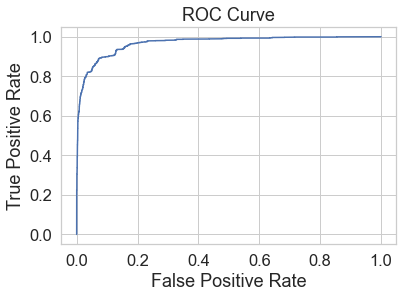

In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_train2, [i[1] for i in model2.predict_proba(X_train2)])
plt.step(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve");

### Generating Test Prediction

Here I am generating the test predictions for submission to the online autograder to see see the test accuracy.

In [17]:
#running predictions on our feature engineered test data
test_predictions = model2.predict(feature_eng(test['email'], email_words))

In [18]:
from datetime import datetime

submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))

Created a CSV file: submission_2023-03-08T17:14:12.csv.


## Submission

(Code Given) The cell below will generate a zip file to submit. **Must save before exporting!**

In [63]:
# Save your notebook first, then run this cell to export your submission.
grader.export()